<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/3_Input_classification_Fire_detection_2023_2024_tfInno2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Tue Oct 24 15:13:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)

Tensorflow version: 2.14.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [3]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [4]:
!rm -rf sample_data
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_2.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_3.zip
! unzip small.zip -d 'bases'
! unzip FIRE_DATABASE_1.zip -d 'bases'
! unzip FIRE_DATABASE_2.zip -d 'bases'
! unzip FIRE_DATABASE_3.zip -d 'bases'
! rm small.zip
! rm FIRE_DATABASE_1.zip
! rm FIRE_DATABASE_2.zip
! rm FIRE_DATABASE_3.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: bases/small/no_fire/00000184.jpg  
  inflating: bases/small/no_fire/00000185.jpg  
  inflating: bases/small/no_fire/00000186.jpg  
  inflating: bases/small/no_fire/00000187.jpg  
  inflating: bases/small/no_fire/00000191.jpg  
  inflating: bases/small/no_fire/00000193.jpg  
  inflating: bases/small/no_fire/00000194.jpg  
  inflating: bases/small/no_fire/00000195.jpg  
  inflating: bases/small/no_fire/00000196.jpg  
  inflating: bases/small/no_fire/00000197.jpg  
  inflating: bases/small/no_fire/00000198.jpg  
  inflating: bases/small/no_fire/00000199.jpg  
  inflating: bases/small/no_fire/00000200.jpg  
  inflating: bases/small/no_fire/00000201.jpg  
  inflating: bases/small/no_fire/00000202.jpg  
  inflating: bases/small/no_fire/00000203.jpg  
  inflating: bases/small/no_fire/00000204.jpg  
  inflating: bases/small/no_fire/00000205.jpg  
  inflating: bases/small/no_fire/00000207.jpg  
  inflatin

#**4. Téléchargement des données de test "Test Dataset"**

In [5]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip -d 'bases'
!rm test.zip

--2023-10-24 15:18:47--  https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  11.2MB/s    in 5.1s    

2023-10-24 15:18:54 (10.7 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: bases/test/
   creating: bases/test/fire/
  inflating: bases/test/fire/F_1001.jpg  
  inflating: bases/test/fire/F_2062.jpg  
  inflating: bases/test/fire/F_2063.jpg  
  inflating: bases/test/fire/F_2064.jpg  
  inflating: bases/test/fire/F_2066.jpg  
  inflating: bases/test/fire/F_2067.jpg  
  inflating: bases/test/fire/F_2068.jpg  
  inflating: bases/test/fire/F_2070.jpg  
  inflating: bases/test/fire/F_2071.jpg  
  inflat

#**5. Création du fichier de labels "classes.txt"**

In [6]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=10 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)

Found 791 files belonging to 3 classes.
Using 633 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)
print(val_ds.class_names)

Found 791 files belonging to 3 classes.
Using 158 files for validation.
['fire', 'no_fire', 'start_fire']


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [11]:
model_xception = Xception(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_xception = Model(inputs = model_xception.inputs, outputs=predictions)


83683744/83683744 [==============================] - 5s 0us/step


In [13]:
model_VGG16 = VGG16(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_VGG16.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG16 = Model(inputs = model_VGG16.inputs, outputs=predictions)


# **10.1 Analyser/visualiser l'architecture de votre modèle avec la fonction summary()**

# **11. Geler puis dégeler les poids des premières couches**

In [14]:
for layer in model_xception.layers:
        layer.trainable = True

In [15]:
for layer in model_VGG16.layers:
        layer.trainable = True
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [16]:
# recompiler le modèle
#??????????????????????????????????????????????????????????????????????????????????????????????
model_xception.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [17]:
model_VGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [18]:
model_VGG16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [19]:
model_xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

# **12. Entraîner le modèle**

In [20]:
history_xception=model_xception.fit(
    train_ds,
#    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
 #   validation_steps=math.ceil(len(val_ds)),
#    verbose=1
)
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

Epoch 1/10
80/80 [==============================] - 60s 379ms/step - loss: 1.0403 - categorical_accuracy: 0.5150 - val_loss: 0.9863 - val_categorical_accuracy: 0.6519
Epoch 2/10
80/80 [==============================] - 27s 312ms/step - loss: 0.9355 - categorical_accuracy: 0.6714 - val_loss: 0.8765 - val_categorical_accuracy: 0.7595
Epoch 3/10
80/80 [==============================] - 29s 333ms/step - loss: 0.8423 - categorical_accuracy: 0.7109 - val_loss: 0.8051 - val_categorical_accuracy: 0.7848
Epoch 4/10
80/80 [==============================] - 25s 289ms/step - loss: 0.7988 - categorical_accuracy: 0.7156 - val_loss: 0.7428 - val_categorical_accuracy: 0.7911
Epoch 5/10
80/80 [==============================] - 26s 301ms/step - loss: 0.7222 - categorical_accuracy: 0.7457 - val_loss: 0.6824 - val_categorical_accuracy: 0.8038
Epoch 6/10
80/80 [==============================] - 25s 291ms/step - loss: 0.6843 - categorical_accuracy: 0.7583 - val_loss: 0.6309 - val_categorical_accuracy: 0.810

In [21]:
history_VGG16=model_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
80/80 [==============================] - 38s 353ms/step - loss: 0.5011 - categorical_accuracy: 0.8152 - val_loss: 0.3221 - val_categorical_accuracy: 0.8861
Epoch 2/10
80/80 [==============================] - 26s 303ms/step - loss: 0.1657 - categorical_accuracy: 0.9447 - val_loss: 0.3973 - val_categorical_accuracy: 0.8924
Epoch 3/10
80/80 [==============================] - 25s 303ms/step - loss: 0.0999 - categorical_accuracy: 0.9621 - val_loss: 0.2918 - val_categorical_accuracy: 0.8924
Epoch 4/10
80/80 [==============================] - 25s 303ms/step - loss: 0.0841 - categorical_accuracy: 0.9684 - val_loss: 0.3484 - val_categorical_accuracy: 0.8924
Epoch 5/10
80/80 [==============================] - 25s 299ms/step - loss: 0.0207 - categorical_accuracy: 0.9968 - val_loss: 0.2881 - val_categorical_accuracy: 0.9177
Epoch 6/10
80/80 [==============================] - 25s 301ms/step - loss: 0.0128 - categorical_accuracy: 0.9968 - val_loss: 0.3403 - val_categorical_accuracy: 0.905

La fonction suivante permet d’afficher les poids d’une couche. Elle prend en paramètre le modèle et
le nom de la couche dont on souhaite afficher les poids.


In [ ]:
def affichePoids(model, name):
  print ("affichage des poids de la couche", name)

  #afficher les poids qui « arrivent » sur une couche
  WS = model.get_layer(name).get_weights()

  print("weights = ", WS[0] )
  print("biais = ", WS[1] )

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [22]:
model_xception.save("model_xception.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model_VGG16.save("model_xception.h5")
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

#**14. Afficher des courbes d'entrainement/validation**

Text(0, 0.5, 'loss')

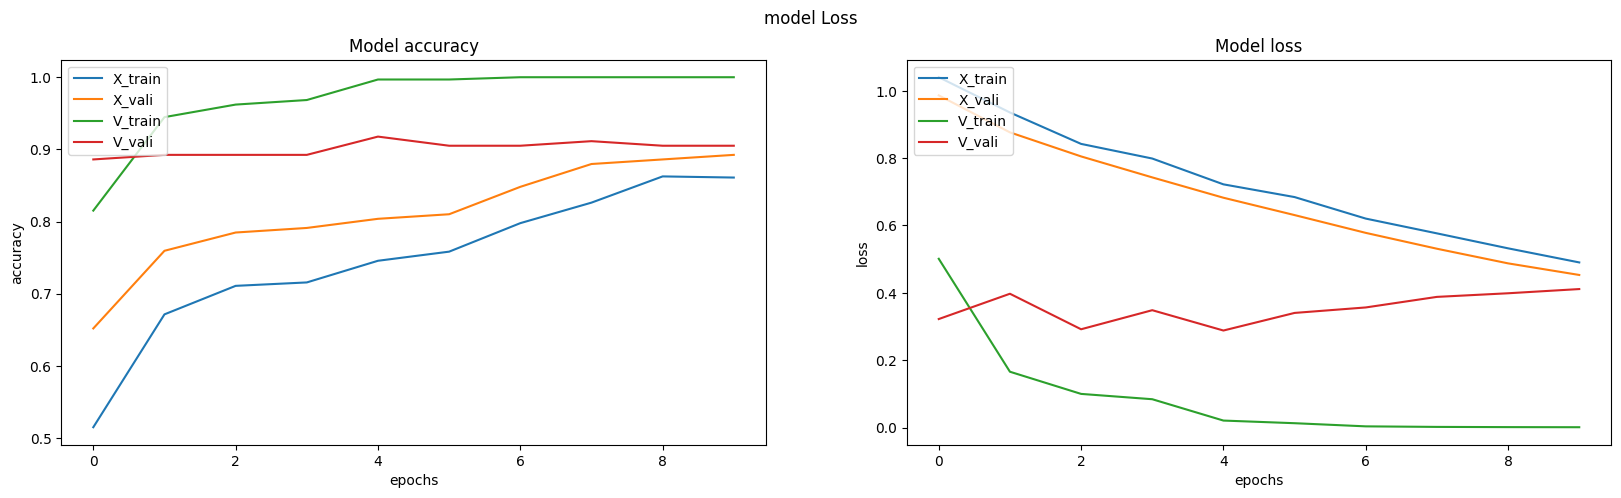

In [24]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('model Loss')

axs[0].plot(history_xception.history["categorical_accuracy"])
axs[0].plot(history_xception.history["val_categorical_accuracy"])
axs[0].plot(history_VGG16.history["categorical_accuracy"])
axs[0].plot(history_VGG16.history["val_categorical_accuracy"])
axs[0].legend(['X_train', 'X_vali', 'V_train', 'V_vali'], loc='upper left')
axs[0].set_title('Model accuracy')
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")

axs[1].plot(history_xception.history["loss"])
axs[1].plot(history_xception.history["val_loss"])
axs[1].plot(history_VGG16.history["loss"])
axs[1].plot(history_VGG16.history["val_loss"])
axs[1].legend(['X_train', 'X_vali', 'V_train', 'V_vali'], loc='upper left')
axs[1].set_title('Model loss')
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("loss")
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **15. Créer le jeu de données de test**

In [25]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset,
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

Found 300 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [26]:
test = model_xception.evaluate(test_ds)
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

38/38 [==============================] - 4s 81ms/step - loss: 0.7426 - categorical_accuracy: 0.6733


In [27]:
test = model_VGG16.evaluate(test_ds)

38/38 [==============================] - 5s 127ms/step - loss: 2.0623 - categorical_accuracy: 0.7333


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [28]:
files.upload()

Saving no_fire.jpg to no_fire.jpg


{'no_fire.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x13\x12\x15\x13\x13\x13\x16\x16\x15\x17\x19\x1f\x1a\x18\x17\x18\x18   \x1a\x1f\x1b \x1d\x1e\x1a!\x18\x1a\x1e\x1e) \x1b\x1b%\x1b\x1a\x1a!1!%)+...\x18\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1b0%\x1f%+2-/-2/+/+---8--------/.----0---------------------\xff\xc0\x00\x11\x08\x00\xa8\x01,\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x06\x02\x03\x04\x00\x01\x07\xff\xc4\x00A\x10\x00\x01\x02\x04\x03\x05\x06\x02\x07\x07\x04\x02\x03\x00\x00\x00\x01\x02\x11\x00\x03!1\x04\x12A\x05"Qaq\x06\x132\x81\x91\xa1\xb1\xf0\x14#Br\xc1\xd1\xe1\x07$3Rb\xb2\xf14C\x82\x92c\xc2\x15\xa2\xa3\xff\xc4\x00\x19\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x01\x00\x05\xff\xc4\x003\x11\x00\x02\x02\x01\x02\x04\x03\x06\x05\x05\x01\x01\x00\x00\x00\x00\x01\x02\x00\x11\x03\x12!\x04"1AQa\xf0\

1/1 [==============================] - 1s 771ms/step
Class Name : fire --- Class Probability: 11.67%
Class Name : no_fire --- Class Probability: 73.76%
Class Name : start_fire --- Class Probability: 14.58%


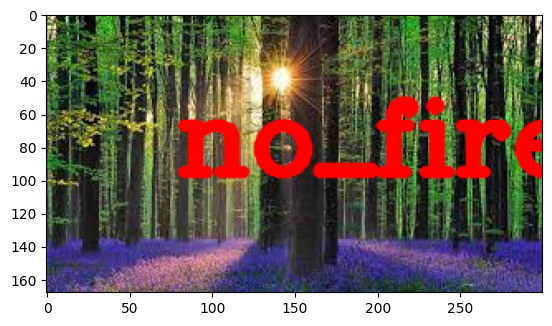

In [29]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_xception.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

1/1 [==============================] - 0s 135ms/step
Class Name : fire --- Class Probability: 0.14%
Class Name : no_fire --- Class Probability: 99.79%
Class Name : start_fire --- Class Probability: 0.07%


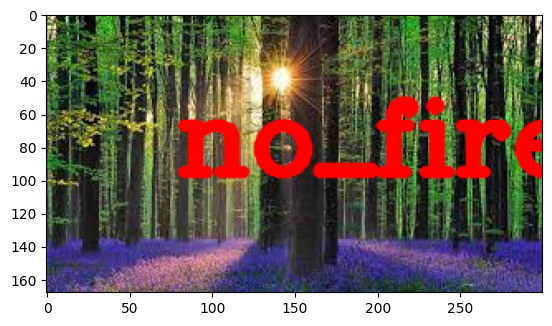

In [30]:
classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_VGG16.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()